## Similarity to self (the halo effect)

1) We depend on taking two equal independent (no replacement) samples from each metrical form (or metrical variant) and  running the clusterization. ARI/purity should be high to register the effect of within-meter semantic coherence  
2) We distiguish between **metrical forms** (Iamb-4) and **metrical variants** (Iamb-4-mf) and run tests on availiable groups of poems independently  


In [1]:
### load libraries & data
#core
library(topicmodels)
library(tidytext)
library(tidyverse)
library(stringi)
#calculations
library(proxy)
library(ineq)
library(mclust)
#dendrograms
library(ape)
library(ggtree)
library(phylogram)
library(ggdendro)
#visuals
library(hrbrthemes)
library(paletteer)
library(patchwork)
library(ggrepel)
library(plotly)
library(DT)
library(grid)



source("src/poem_sampler.R")
source("src/test_clusters_halo.R")
load("data/lda_output.rda")

options(repr.plot.width = 8, repr.plot.height = 6,unit="cm")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘proxy’


The following objects are masked from ‘package:stats’:

    as.dist, dist


The following object is masked from ‘package:base’:

    as.matrix


Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mclust’


The following object is masked from ‘package:purrr’:

    map


Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

ggtree v2.0.4  For help: https://yulab-smu.github.io/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

- Guan

In [33]:
?options()

## Consensus tree

Build CT similarly to metrical families:  

1) calculates h. clusters for each sample, converts to trees -> repeat  
2) build consensus tree with ape, draw unrooted tree with ggtree

In [98]:
source("src/consensus_tree_within_meter.R")

trees = consensus_tree_within_meter(x=unique_poems,
                           y=meter_count,
                           z=ru_gamma_separated,
                           sample_size=200,
                           n_samples=2,
                           n_trees = 100,
                           min_meter_count=500,
                           replace=F,
                           distance="Kullback",
                           clust_method="ward.D2")

In [100]:
trans = translation  %>% rename(class = meter)
library(ggtree)
consensus = ape::consensus(trees, p=0.5)

plot=ggtree(consensus,layout="circular",size=0.5) 

plot$data = plot$data  %>%
         mutate(class = str_replace_all(label, "^(.*)_\\d$", "\\1"))  %>% 
         left_join(trans, by="class")  %>% 
         group_by(meter_eng)  %>% 
         mutate(sample = row_number())  %>% 
         unite(meter_eng, meter_eng:sample,sep="_")  %>% 
         ungroup()  %>% 
         mutate(label = case_when(!is.na(label) ~ meter_eng))
cons_plot1 = plot + geom_tiplab(aes(color=class),hjust=-.1,size=2.5,) + guides(color=F) + #scale_color_paletteer_d(rep("ghibli::MononokeDark",2))
 scale_color_manual(values=c(rep(paletteer_d("ghibli::MononokeMedium"),2))) + labs(title="a") + xlim(0,6)

In [11]:
ggsave("plots/consensus_within.png", height=5, width=6, unit="cm")

## Metrical variants of Iamb-4

In [15]:
iamb_forms = meter_claus_count  %>% 
    filter(str_detect(meter, "Я4_"), n>=200, !str_detect(meter,"Х5|Х6"), !str_detect(meter,"_жм$"))  

iamb_forms

meter,n
<chr>,<int>
"Я4_ж,м",1709
Я4_мж,1611
Я4_м,366
Я4_дм,226


In [16]:
iamb_trees = consensus_tree_within_meter(x=unique_poems  %>% unite("meter", meter:clausula),
                           y=iamb_forms,
                           z=ru_gamma_separated,
                           sample_size=100,
                           n_samples=2,
                           n_trees = 100,
                           min_meter_count=-Inf,
                           replace=F,
                           distance="Kullback",
                           clust_method="ward.D2")

In [80]:
consensus = ape::consensus(iamb_trees, p=0.5)

plot=ggtree(consensus,layout="circular",size=0.5) 

plot$data = plot$data  %>%
         mutate(class = str_replace_all(label, "^(.*)_\\d$", "\\1"))  %>% 
         left_join(trans, by="class")  %>% 
         group_by(meter_eng)  %>% 
         mutate(sample = row_number())  %>% 
         unite(meter_eng, meter_eng:sample,sep="_")  %>% 
         ungroup()  %>% 
         mutate(label = case_when(!is.na(label) ~ meter_eng))


cons_plot2 = plot + geom_tiplab(aes(color=class),hjust=-.1,size=3) + guides(color=F) + #scale_color_paletteer_d(rep("ghibli::MononokeDark",2))
 scale_color_manual(values=c(rep(paletteer_d("ghibli::MononokeMedium"),2))) + labs(title="b") + xlim(0,8) +ylim(0,8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



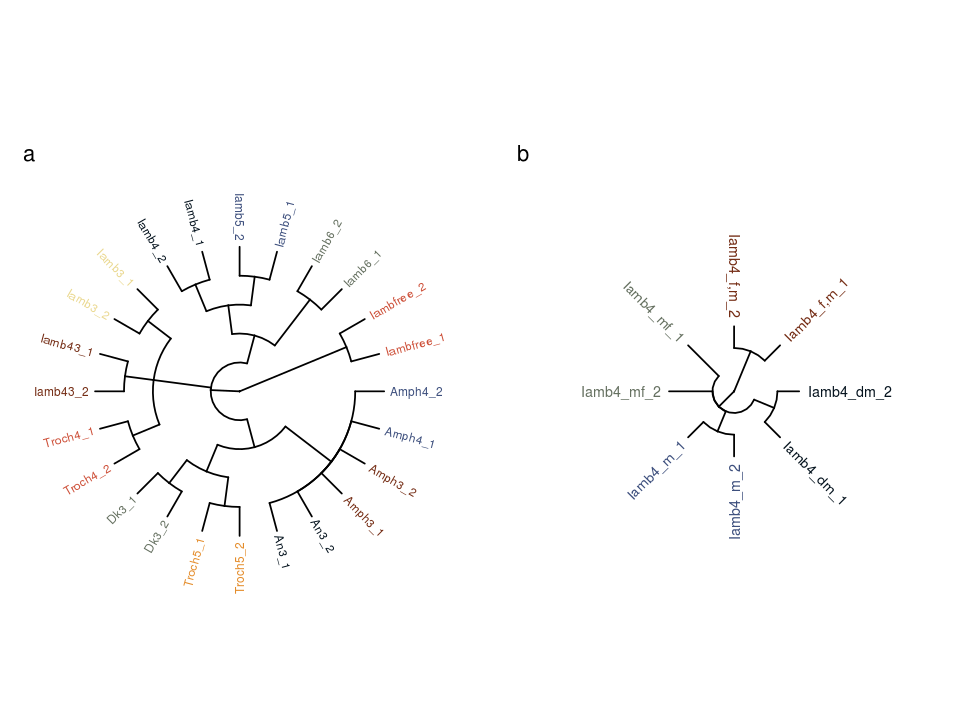

In [93]:
patch = cons_plot1 + cons_plot2

patch + theme(plot.margin =  margin(1, 0, 0, 1, "cm"))
ggsave("plots/consensus_trees.png", height=4, width=6)



In [126]:
ggsave("plots/consensus_variants.png", height=5, width=6, unit="cm")

## Clustering accuracy


Check how clusterization efficiency depends on sample size (how many poems per sample) in **metrical forms** 

1) Run n iterations per sample size (poems in each sample representing meter)  
2) Measure ARI and purity in each iteration + run the same thing for randomly assigned clusters  
3) Build a consensus tree on a reasonably well performing set

Then we switch to **metrical variants** and find uninformative variants (bad clustering), get rid of them

1) Check the clusterization efficiency and sample size  
2) Check clusterization efficiency in smaller meters  
3) Build a consensus tree for metrical variants  



In [102]:
source("src/test_clusters_halo.R")

halo_clusters = test_clusters_halo(poem_list=unique_poems,
                         meter_list=meter_count,
                         p_size=c(1,5,10,20,40,60,80,100,120,150,200,250),
                         samples_per_meter=2,
                         iterations=50,
                         min_meter_count=500,
                         rep=FALSE)

random_clusters = test_clusters_halo(poem_list=unique_poems,
                         meter_list=meter_count,
                         p_size=c(1,5,10,20,40,60,80,100,120,150,200,250),
                         samples_per_meter=2,
                         iterations=50,
                         min_meter_count=500,
                         rep=FALSE,
                         random_clusters=T)

[1] "Now at 1 poems"
[1] "Now at 5 poems"
[1] "Now at 10 poems"
[1] "Now at 20 poems"
[1] "Now at 40 poems"
[1] "Now at 60 poems"
[1] "Now at 80 poems"
[1] "Now at 100 poems"
[1] "Now at 120 poems"
[1] "Now at 150 poems"
[1] "Now at 200 poems"
[1] "Now at 250 poems"
[1] "Now at 1 poems"
[1] "Now at 5 poems"
[1] "Now at 10 poems"
[1] "Now at 20 poems"
[1] "Now at 40 poems"
[1] "Now at 60 poems"
[1] "Now at 80 poems"
[1] "Now at 100 poems"
[1] "Now at 120 poems"
[1] "Now at 150 poems"
[1] "Now at 200 poems"
[1] "Now at 250 poems"


In [103]:
halo_clusters  %>% filter(poems_per_sample == 250)  %>% summarise(m_ari = median(ari), m_pur = median(purity))

m_ari,m_pur
<dbl>,<dbl>
0.7427376,0.9166667


In [104]:
ari_plot = halo_clusters  %>% mutate(ari_rand = random_clusters$ari) %>% gather(key="clust", value="index", c(1:2,4))  %>% 
    ggplot(aes(as.factor(poems_per_sample), index, group=interaction(poems_per_sample,clust),color=clust)) + geom_boxplot() +   
theme_ipsum() + labs(x="Sample Size", y="Value",title="c") + theme(axis.title.x = element_text(size=12),
                                                                   axis.title.y = element_text(size=12),
                                                                   plot.margin  = margin(0,0,0,0)) + scale_color_paletteer_d("ghibli::MononokeMedium",direction = -1)

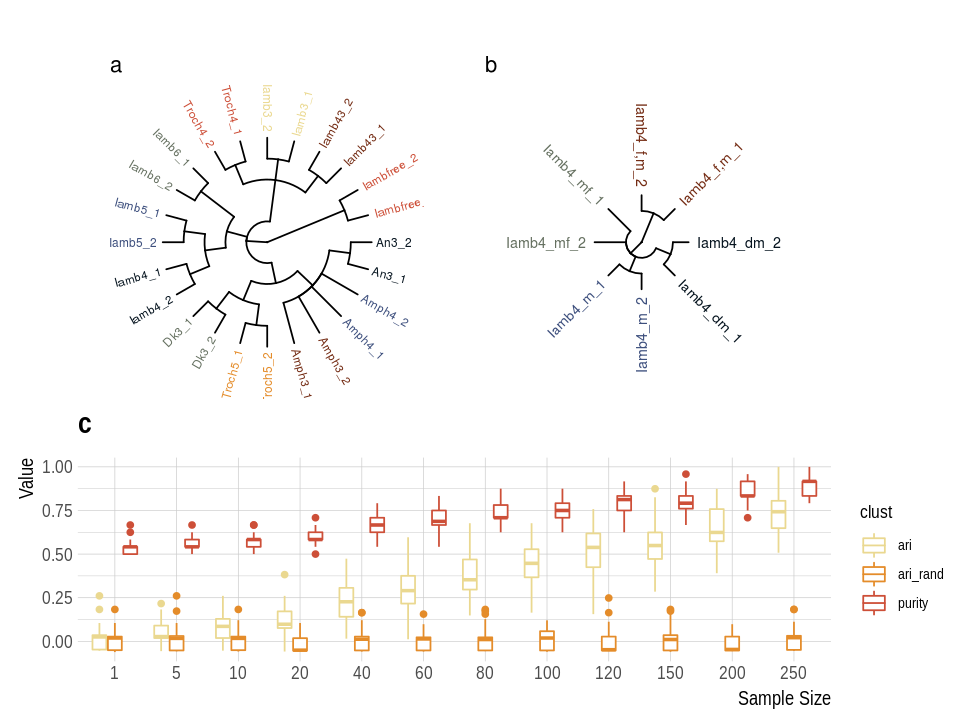

In [106]:
patch = (cons_plot1 | cons_plot2) + theme(plot.margin =  margin(1, 0, 0, 1, "cm"))
patch / ari_plot +  plot_layout(heights = c(2, 1.3))

ggsave("plots/fig2_consensus_ari.png", width=8,height=7)

/////////////////////
## XX. Code Graveyard (really, pls, do not go there)

////////////////////

In [55]:
source("src//test_clusters_halo.R")
source("src//poem_sampler.R")
halo_clusters = test_clusters_halo(poem_list=unique_poems,
                         meter_list=meter_count,
                         p_size=c(1,seq(5,50, by=5)),
                         samples_per_meter=2,
                         iterations=50,
                         max_meter_count=200,
                         min_meter_count=100,
                         rep=F)

[1] "Now at 1 poems"


Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy



[1] "Now at 5 poems"
[1] "Now at 10 poems"
[1] "Now at 15 poems"
[1] "Now at 20 poems"
[1] "Now at 25 poems"
[1] "Now at 30 poems"
[1] "Now at 35 poems"
[1] "Now at 40 poems"
[1] "Now at 45 poems"
[1] "Now at 50 poems"


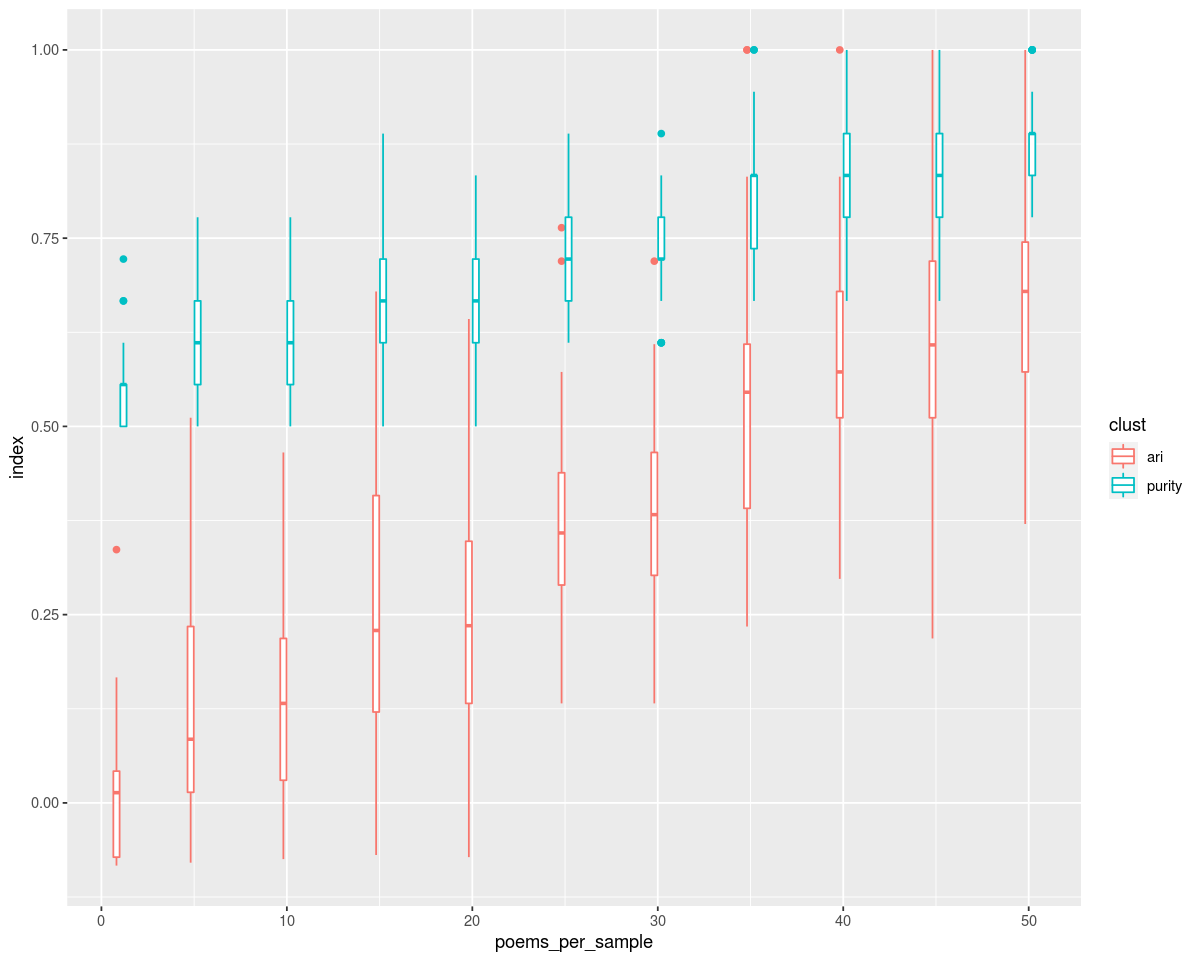

In [70]:
halo_clusters %>% gather(key="clust", value="index", 1:2)  %>% 
    ggplot(aes(poems_per_sample, index, group=interaction(poems_per_sample,clust),color=clust)) + geom_boxplot()  

## Metrical variants simplification

1) It's is wrong to assume that all catalectic variants of metrical form formed equally distinct semantics, e.g. alternation of f/m or m/f in Iambic tetrameter or irregular alternation of f/m clausula.  
2) To trace those "sibling" variants we perform series of clusterization using metrical variants and simply look how "dispersed" is each variant across cluster.  
3) We simply count mean number of clusers each form appears in. Ideal clustering would be 1, very bad = 3.  
4) We look what forms are on average dispersed over more than 2 clusters and -> based on this simplify semantically close variants merging them to one.

In [19]:
ari_vec = vector(length=50)
purity_vec = vector(length=50)

cluster_df = meter_claus_count  %>% filter(n>=400)  %>% select(meter,n) %>% arrange(meter)  %>% mutate(n_clust = 0)


for (i in 1:length(ari_vec)) {

print(paste("Now at", i, sep=" "))
## take 3 samples per each meter
wide_gamma = poem_sampler(x= unique_poems  %>% unite("meter", meter:clausula),
             y=meter_claus_count,
             sample_size=100,
             n_samples=3,
             meter_count_limit=400,
             replace=F) %>% 
    left_join(ru_gamma_separated)  %>%
#    mutate(sample = str_replace(sample,"^.*?_", "")) %>%
    group_by(topic, sample)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    spread(key = topic, value=m_gamma)

## perpare matrix
names = wide_gamma  %>% pull(sample)
wide_matrix = wide_gamma[,-1]  %>% as.matrix()
rownames(wide_matrix) =  names


##calculate distances & build clusterization

tree = wide_matrix  %>% 
    dist(method="Kullback")  %>% 
    hclust(method="ward.D2") 


n_classes = meter_claus_count  %>% 
    filter(n>=400)  %>%
    pull(meter)  %>%
    length()

classes = cutree(tree,k=n_classes)
expected = str_replace_all(names, "_\\d", "")

purity = NMF::purity(as.factor(classes), expected)
ari = mclust::adjustedRandIndex(as.numeric(classes), expected)

    
## checking which forms cluster badly
triplets = split(as.numeric(classes), ceiling(seq_along(classes)/3))
clusters_per_class = sapply(triplets,unique)  %>% sapply(length)

cluster_df = cluster_df  %>% mutate(n_clust = n_clust + clusters_per_class)
    

purity_vec[i] = purity
ari_vec[i] = ari
}

cluster_df = cluster_df  %>% mutate(avg_clust = n_clust/length(ari_vec))

[1] "Now at 1"


Joining, by = "id"



[1] "Now at 2"


Joining, by = "id"



[1] "Now at 3"


Joining, by = "id"



[1] "Now at 4"


Joining, by = "id"



[1] "Now at 5"


Joining, by = "id"



[1] "Now at 6"


Joining, by = "id"



[1] "Now at 7"


Joining, by = "id"



[1] "Now at 8"


Joining, by = "id"



[1] "Now at 9"


Joining, by = "id"



[1] "Now at 10"


Joining, by = "id"



[1] "Now at 11"


Joining, by = "id"



[1] "Now at 12"


Joining, by = "id"



[1] "Now at 13"


Joining, by = "id"



[1] "Now at 14"


Joining, by = "id"



[1] "Now at 15"


Joining, by = "id"



[1] "Now at 16"


Joining, by = "id"



[1] "Now at 17"


Joining, by = "id"



[1] "Now at 18"


Joining, by = "id"



[1] "Now at 19"


Joining, by = "id"



[1] "Now at 20"


Joining, by = "id"



[1] "Now at 21"


Joining, by = "id"



[1] "Now at 22"


Joining, by = "id"



[1] "Now at 23"


Joining, by = "id"



[1] "Now at 24"


Joining, by = "id"



[1] "Now at 25"


Joining, by = "id"



[1] "Now at 26"


Joining, by = "id"



[1] "Now at 27"


Joining, by = "id"



[1] "Now at 28"


Joining, by = "id"



[1] "Now at 29"


Joining, by = "id"



[1] "Now at 30"


Joining, by = "id"



[1] "Now at 31"


Joining, by = "id"



[1] "Now at 32"


Joining, by = "id"



[1] "Now at 33"


Joining, by = "id"



[1] "Now at 34"


Joining, by = "id"



[1] "Now at 35"


Joining, by = "id"



[1] "Now at 36"


Joining, by = "id"



[1] "Now at 37"


Joining, by = "id"



[1] "Now at 38"


Joining, by = "id"



[1] "Now at 39"


Joining, by = "id"



[1] "Now at 40"


Joining, by = "id"



[1] "Now at 41"


Joining, by = "id"



[1] "Now at 42"


Joining, by = "id"



[1] "Now at 43"


Joining, by = "id"



[1] "Now at 44"


Joining, by = "id"



[1] "Now at 45"


Joining, by = "id"



[1] "Now at 46"


Joining, by = "id"



[1] "Now at 47"


Joining, by = "id"



[1] "Now at 48"


Joining, by = "id"



[1] "Now at 49"


Joining, by = "id"



[1] "Now at 50"


Joining, by = "id"



In [139]:
cluster_df  %>% filter(avg_clust > 2)

[1] 0.7743333

[1] 0.5648555

[1] 0.7000000 0.7833333 0.7000000 0.8166667 0.7666667 0.7500000 0.7333333
 [8] 0.7666667 0.7333333 0.7666667 0.8333333 0.8000000 0.7666667 0.8333333
[15] 0.7500000 0.8166667 0.7666667 0.8666667 0.7500000 0.8166667 0.7833333
[22] 0.7666667 0.7833333 0.7000000 0.7166667 0.7500000 0.8000000 0.8000000
[29] 0.8166667 0.7333333 0.7166667 0.7000000 0.8000000 0.8666667 0.7500000
[36] 0.8666667 0.7166667 0.7833333 0.7666667 0.8333333 0.8166667 0.7500000
[43] 0.7666667 0.7833333 0.7333333 0.7666667 0.7666667 0.7833333 0.8166667
[50] 0.7666667

[1] 0.4455328 0.5850709 0.4876117 0.6228311 0.5567358 0.5291415 0.5193167
 [8] 0.5585289 0.5016149 0.5350844 0.6743758 0.6074364 0.5458578 0.6592344
[15] 0.5095718 0.6433848 0.5567358 0.7543318 0.5137363 0.6651903 0.5766471
[22] 0.5482874 0.5658344 0.4445465 0.4898187 0.5108808 0.6219496 0.6281672
[29] 0.6173395 0.4947103 0.4727989 0.4136646 0.5498437 0.7151990 0.5236267
[36] 0.7363995 0.4501259 0.5818619 0.5261658 0.6434066 0.6325260 0.5135453
[43] 0.5567358 0.6088806 0.4947103 0.5720207 0.5439213 0.5634845 0.6329583
[50] 0.5413942

meter,n,n_clust,avg_clust
<chr>,<int>,<dbl>,<dbl>
Х4_жм,2837,109,2.18
"Х4_ж,м",622,117,2.34
Я4_жм,5730,104,2.08
"Я4_ж,м",2141,132,2.64
Я4_мж,1935,101,2.02
Я5_жм,2548,104,2.08
"Я5_ж,м",1032,120,2.40
Я6_жм,1189,102,2.04
"Я6_ж,м",592,118,2.36


## Remove uninformative variants from data

1) As expected, the most cluster dispersion happened in common f/m or m/f alternating catalectic variants  
2) We remove those variants, leaving the most common form which is f/m regular alternation for Iamb-4, Iamb-5, Iamb-6 & Troch-4

In [2]:
# metrical variants with bad clustering


m_claus_simplified = meter_claus_count  %>%
    filter(!meter %in% c("Х4_ж,м","Я4_ж,м","Я4_мж","Я5_ж,м","Я6_ж,м"))

unique_poems_simplified = unique_poems  %>% unite("meter", meter:clausula)  %>%
         filter(!meter %in% c("Х4_ж,м","Я4_ж,м","Я4_мж","Я5_ж,м","Я6_ж,м"))

head(m_claus_simplified)


meter,n
<chr>,<int>
Я4_жм,4142
Х4_жм,2064
Я5_жм,1980
Я5_мж,1258
Явольн_вольн,1073
Я6_жм,947


## Clustering performance on simplified metrical variants

In [17]:
variants_simple_res = test_clusters_halo(poem_list=unique_poems_simplified,
                         meter_list=m_claus_simplified,
                         p_size=c(seq(10,120,by=10)),
                         samples_per_meter=3,
                         iterations=50,
                         min_meter_count=400,          
                         rep=FALSE)

variants_res = test_clusters_halo(poem_list=unique_poems  %>% unite("meter", meter:clausula),
                         meter_list=meter_claus_count,
                         p_size=c(seq(10,120,by=10)),
                         samples_per_meter=3,
                         iterations=50,
                         min_meter_count=400,          
                         rep=FALSE)

## smaller meters


[1] "Now at 10 poems"
[1] "Now at 20 poems"
[1] "Now at 30 poems"
[1] "Now at 40 poems"
[1] "Now at 50 poems"
[1] "Now at 60 poems"
[1] "Now at 70 poems"
[1] "Now at 80 poems"
[1] "Now at 90 poems"
[1] "Now at 100 poems"
[1] "Now at 110 poems"
[1] "Now at 120 poems"
[1] "Now at 10 poems"
[1] "Now at 20 poems"
[1] "Now at 30 poems"
[1] "Now at 40 poems"
[1] "Now at 50 poems"
[1] "Now at 60 poems"
[1] "Now at 70 poems"
[1] "Now at 80 poems"
[1] "Now at 90 poems"
[1] "Now at 100 poems"
[1] "Now at 110 poems"
[1] "Now at 120 poems"


[1] 0.3818698

[1] 0.3372825

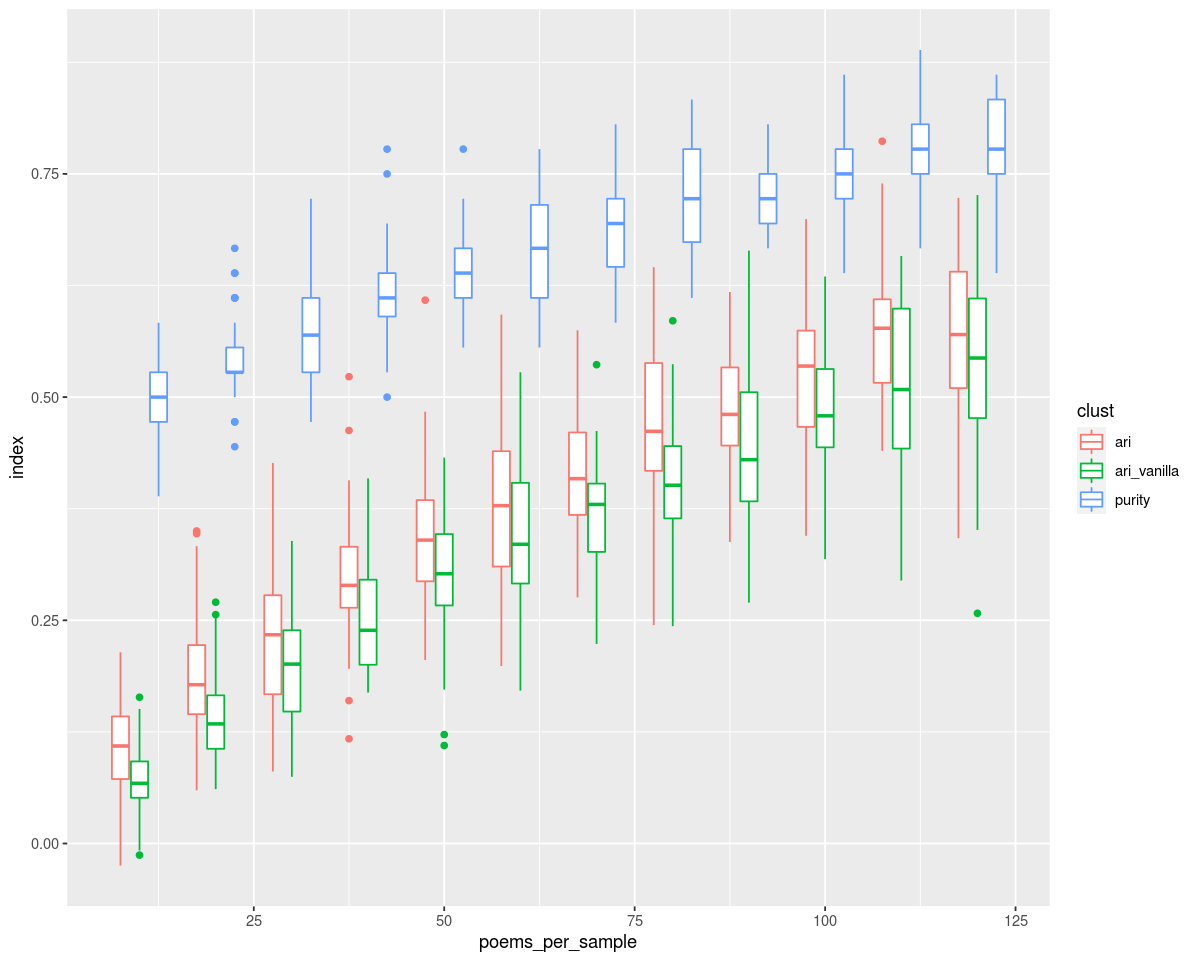

In [31]:
mean(variants_simple_res$ari)
mean(variants_res$ari)

variants_simple_res  %>% mutate(ari_vanilla = variants_res$ari) %>% 
    gather(key="clust", value="index", c(1:2,4))  %>% 
    ggplot(aes(poems_per_sample, index, group=interaction(clust,poems_per_sample),color=clust)) + geom_boxplot()

In [18]:
variants_small = test_clusters_halo(poem_list=unique_poems  %>% unite("meter", meter:clausula),
                         meter_list=meter_claus_count,
                         p_size=c(5,seq(10,100,by=10)),
                         samples_per_meter=2,
                         iterations=100,
                         min_meter_count=200,
                         max_meter_count=400,          
                         rep=FALSE)


[1] "Now at 5 poems"
[1] "Now at 10 poems"
[1] "Now at 20 poems"
[1] "Now at 30 poems"
[1] "Now at 40 poems"
[1] "Now at 50 poems"
[1] "Now at 60 poems"
[1] "Now at 70 poems"
[1] "Now at 80 poems"
[1] "Now at 90 poems"
[1] "Now at 100 poems"


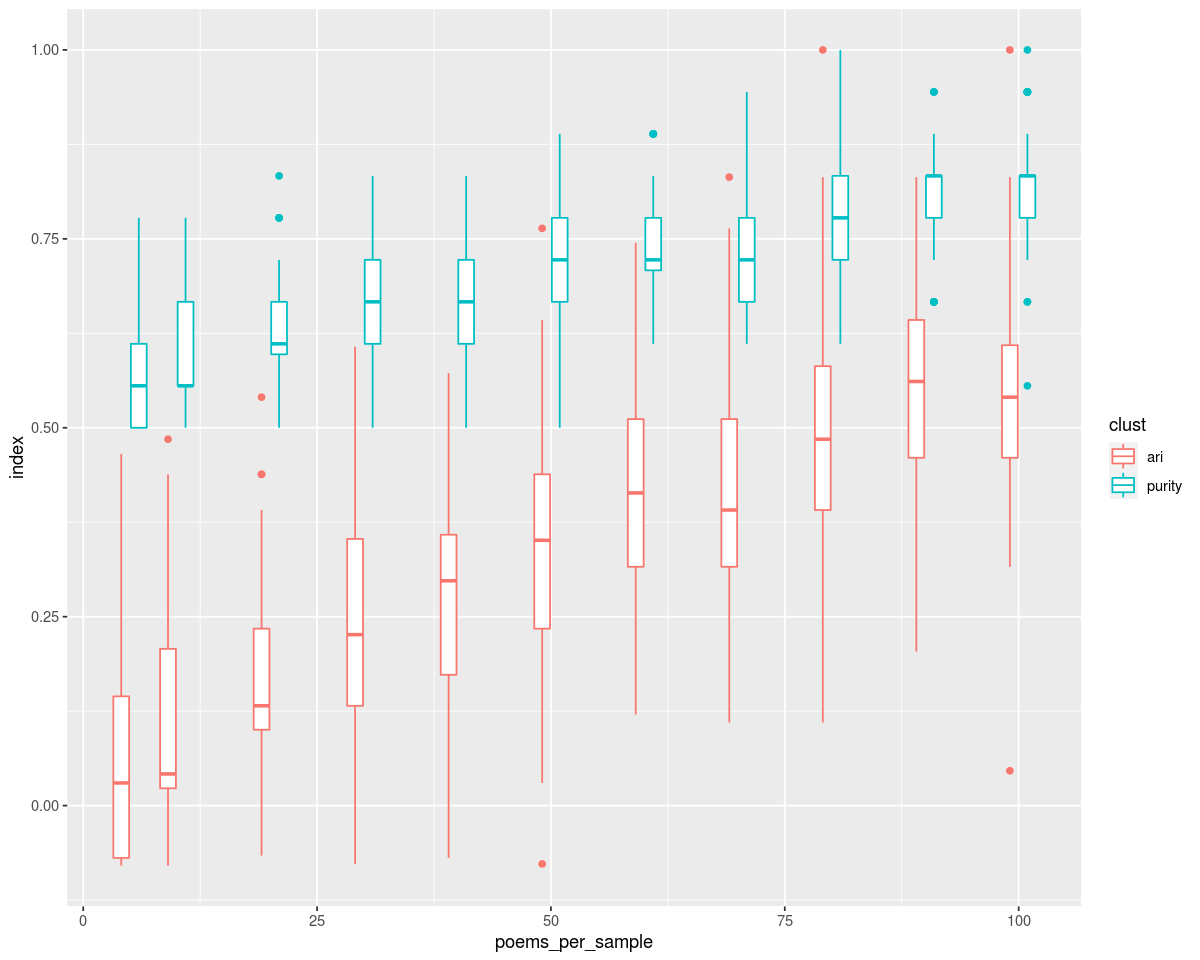

In [19]:
variants_small  %>% gather(key="clust", value="index", c(1:2))  %>% 
    ggplot(aes(poems_per_sample, index, group=interaction(clust,poems_per_sample),color=clust)) + geom_boxplot()

## XX. Code backyard

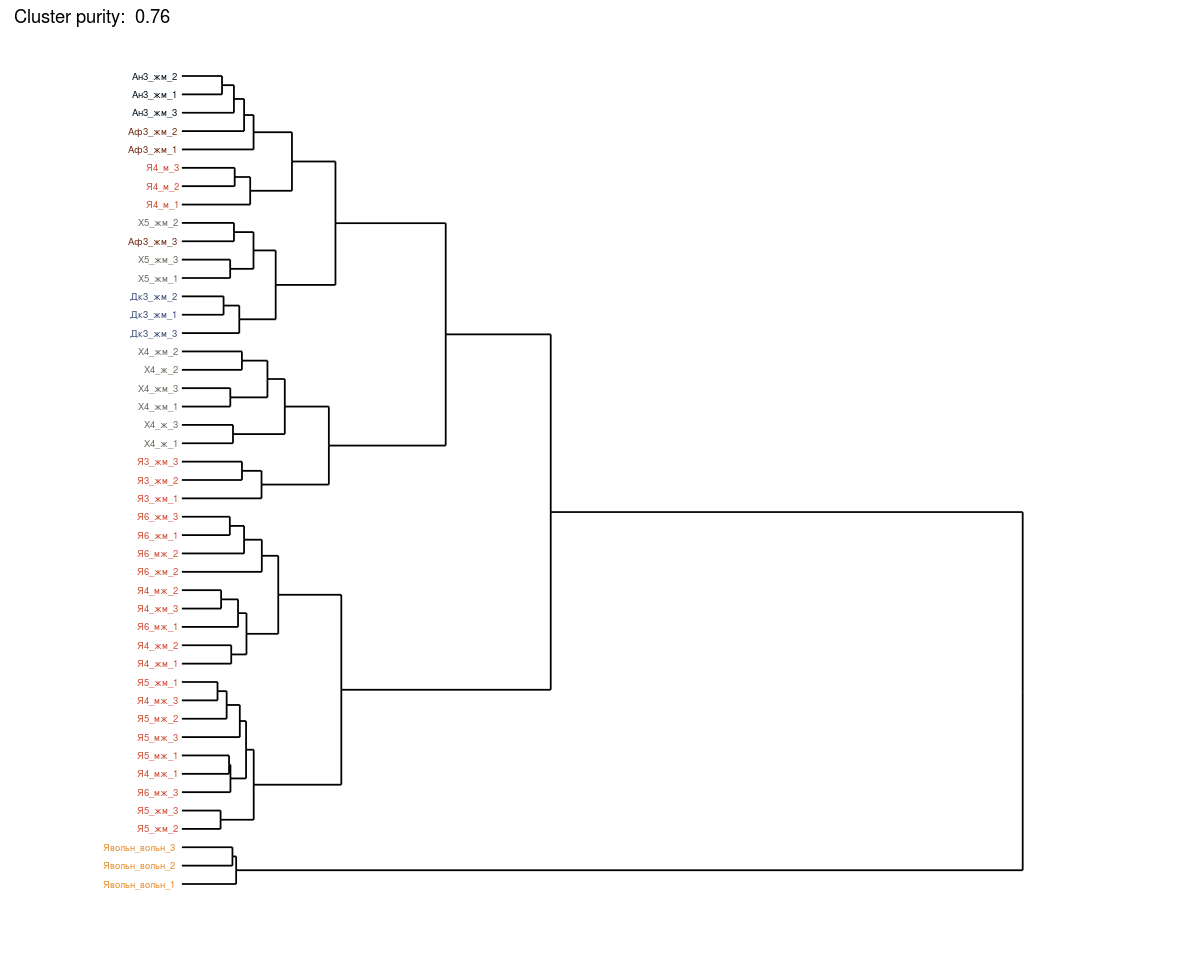

In [46]:
ggtree = tree  %>%
    as.dendrogram() %>%
    dendro_data()

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

ggplot() +
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=2) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d("ghibli::MononokeMedium") +
  guides(color=F) +
  labs(subtitle=paste("Cluster purity: ", round(purity,2)))

### Draw a dendrogram out of single clusterization

Joining, by = "id"



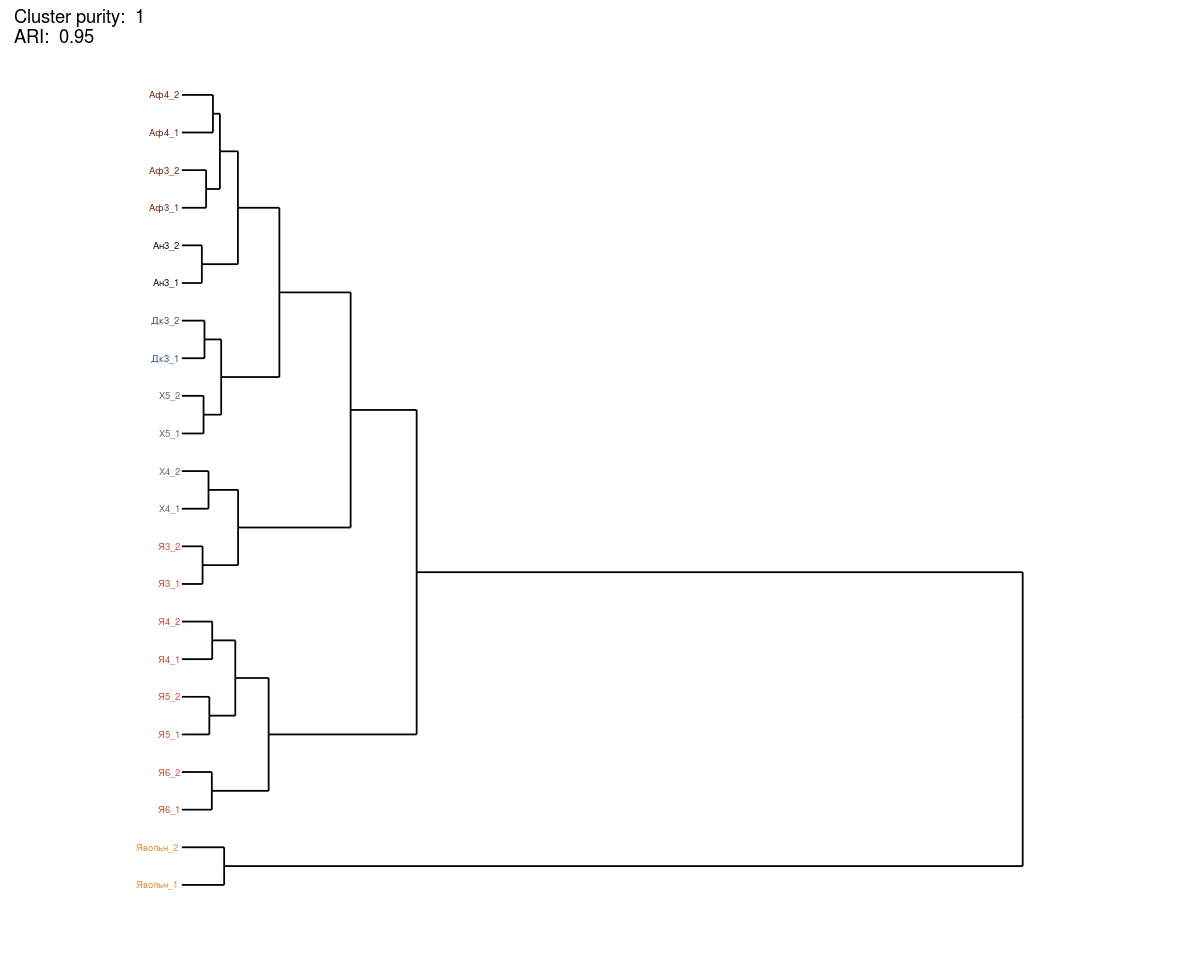

In [67]:

## take 3 samples per each meter
wide_gamma = poem_sampler(x= unique_poems,  #%>% unite("meter", meter:clausula),
             y=meter_count,
             sample_size=250,
             n_samples=2,
             meter_count_limit=500,
             replace=F) %>% 
    left_join(ru_gamma_separated)  %>%
#    mutate(sample = str_replace(sample,"^.*?_", "")) %>%
    group_by(topic, sample)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    spread(key = topic, value=m_gamma)

## perpare matrix
names = wide_gamma  %>% pull(sample)
wide_matrix = wide_gamma[,-1]  %>% as.matrix()
rownames(wide_matrix) =  names


##calculate distances & build clusterization

tree = wide_matrix  %>% 
#    scale()  %>% 
    dist(method="Kullback")  %>% 
    hclust(method="ward.D2") 


n_classes = meter_count  %>% 
    filter(n>=400)  %>%
    pull(meter)  %>%
    length()

classes = cutree(tree,k=n_classes)
expected = str_replace_all(names, "_\\d", "")


purity = NMF::purity(as.factor(classes), expected)
ari = mclust::adjustedRandIndex(as.numeric(classes), expected)

ggtree = tree  %>%
    as.dendrogram() %>%
    dendro_data()

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

ggplot() +
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=2) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d("ghibli::MononokeMedium") +
  guides(color=F) +
  labs(subtitle=paste("Cluster purity: ", round(purity,2),"\nARI: ", round(ari,2)))